# Table of Contents

## 1. Data Loading
## 2. Normalize
## 3. Score
- credibility
- exposure, party mentioned

In [1]:
import json, time

import numpy as np
import pandas as pd
import itertools as it
import networkx as nx

from datetime import datetime
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

## 1. Data Loading

### Setup

In [3]:
path = "/home/yuvenious/election_tweets"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
# informations from "user"
user_keys = ["created_at", "verified", #age, verified
             "followers_count", "friends_count", #reputation ratio
             "favourites_count", "statuses_count", #posts, likes
             "description"] #profile description

### Extract

In [5]:
archive_path = "./Archive/Network/"
filepath = archive_path+'result_r2.pdf'
pdf_pages = PdfPages(filepath)

In [6]:
start = time.time()
for i, jfile in enumerate(onlyfiles[:]):
    fullpath = join(path, jfile)
    print(i, "%s started"%jfile)
    start = time.time()
    with open(fullpath, "r") as f:
        data = json.load(f)
        time_dict = {}
        for tweet in data:
            id_in_keys = "id" in tweet.keys()
            text_in_keys = "text" in tweet.keys()
            if id_in_keys & text_in_keys:
                text_none = tweet["text"] == None
                if not text_none:
                    user_info = {k: tweet["user"][k] for k in user_keys}
                    user_info["hasDescription"] = user_info["description"] != None
                    time_dict[tweet["id"]] = user_info
        np.save(archive_path+"info_network%s.npy"%i, time_dict)
        print(i, "%s saved"%jfile)
    end = time.time()
    print(i, "%s finished"%jfile, len(time_dict), round(end-start, 2), "sec")

0 full_tweet_non_english2202.json started
0 full_tweet_non_english2202.json saved
0 full_tweet_non_english2202.json finished 54080 5.05 sec
1 full_tweet_non_english2303.json started
1 full_tweet_non_english2303.json saved
1 full_tweet_non_english2303.json finished 131629 11.97 sec
2 full_tweet_non_english5303.json started
2 full_tweet_non_english5303.json saved
2 full_tweet_non_english5303.json finished 115525 11.18 sec
3 full_tweet_non_english3303.json started
3 full_tweet_non_english3303.json saved
3 full_tweet_non_english3303.json finished 135285 11.57 sec
4 full_tweet_non_english4303.json started
4 full_tweet_non_english4303.json saved
4 full_tweet_non_english4303.json finished 146090 12.64 sec
5 full_tweet_non_english1202.json started
5 full_tweet_non_english1202.json saved
5 full_tweet_non_english1202.json finished 96057 9.51 sec
6 full_tweet_non_english6303.json started
6 full_tweet_non_english6303.json saved
6 full_tweet_non_english6303.json finished 21682 2.1 sec
7 full_tweet_

In [7]:
# preview
pd.DataFrame(time_dict).T.tail()

,created_at,description,favourites_count,followers_count,friends_count,hasDescription,statuses_count,verified
962586633987006464,Mon Aug 03 04:52:30 +0000 2015,活動場所：デレステ、グラブル、ミリシタ 765響 デレみくにゃん、よしのん等Pa全般 ...,2954,121,157,True,24538,False
962586645806637056,Thu Mar 22 21:13:41 +0000 2012,| Anti EU | Anti HALLAL | Anti €€€ | Pro PVV |...,11762,5622,5619,True,24829,False
962586675187802112,Sun Apr 30 19:04:16 +0000 2017,None,37959,258,405,False,23225,False
962586722541473792,Tue Jan 31 22:27:59 +0000 2017,"vrijdenker, atheïst, republikein.",514,212,169,True,11929,False
962586725926293504,Thu Jul 06 17:10:11 +0000 2017,None,27188,131,152,False,13503,False


### Archive

In [8]:
# load numpy files
all_info = {}
for i in range(len(onlyfiles)):
    dict_path = archive_path+"info_network%s.npy"%i
    tweets = np.load(dict_path).item()
    all_info.update(tweets)

#transfer to datetime object
df = pd.DataFrame(all_info).T
df["created_at"] = df["created_at"].apply(lambda x: datetime.strptime(x, "%a %b %d %X %z %Y")).values

#calculate Age: reference date as 2018/03/22 (the last of the entire tweets dataset)
ref_date = datetime(2018, 3, 22).date()
days_created = df[:]["created_at"].apply(lambda x: ref_date - x.date())
df["created_at"] = days_created.apply(lambda x: x.days).values

#calculate Reputation ratio (plus 1, in order to prevent divide by zero)
df["rep_ratio"] = ((df["followers_count"] + 1)/(df["friends_count"] + 1)).values

#drop irrelevant columns
df.drop(["friends_count", "description"], axis=1, inplace=True)

#archive
df.columns = ["Age", "Likes", "Followers", "HasDescription", "Posts", "IsVerified","Rep_ratio"]
df.to_csv(archive_path+"all_info.csv")

### Load

In [9]:
df = pd.read_csv(archive_path+"all_info.csv", index_col=0)
print(df.shape)
df.head()

(795867, 7)


,Age,Likes,Followers,HasDescription,Posts,IsVerified,Rep_ratio
971292052045680640,24,129,7,False,168,False,0.347826
971292069305122816,1986,2993,20,False,2608,False,0.600000
971292104981958658,24,130,7,False,169,False,0.347826
971292122035957760,923,7641,384,True,6253,False,0.797101
971292169154781184,765,385,175,True,897,False,0.239782


## 2. Normalize

In [10]:
from sklearn.preprocessing import MinMaxScaler
# range: 1~5 (prevent divided by zero)
scale = MinMaxScaler(feature_range=(1, 5))

In [11]:
df.head()

,Age,Likes,Followers,HasDescription,Posts,IsVerified,Rep_ratio
971292052045680640,24,129,7,False,168,False,0.347826
971292069305122816,1986,2993,20,False,2608,False,0.600000
971292104981958658,24,130,7,False,169,False,0.347826
971292122035957760,923,7641,384,True,6253,False,0.797101
971292169154781184,765,385,175,True,897,False,0.239782


In [12]:
df_norm = pd.DataFrame(data = scale.fit_transform(df), columns=df.columns, index=df.index)
df_norm.head(5)

,Age,Likes,Followers,HasDescription,Posts,IsVerified,Rep_ratio
971292052045680640,1.022493,1.000605,1.000003,1.0,1.000194,1.0,1.000000
971292069305122816,2.861293,1.014032,1.000010,1.0,1.003035,1.0,1.000000
971292104981958658,1.022493,1.000609,1.000003,1.0,1.000196,1.0,1.000000
971292122035957760,1.865042,1.035824,1.000191,5.0,1.007278,1.0,1.000001
971292169154781184,1.716963,1.001805,1.000087,5.0,1.001043,1.0,1.000000


### Check the distribution of values

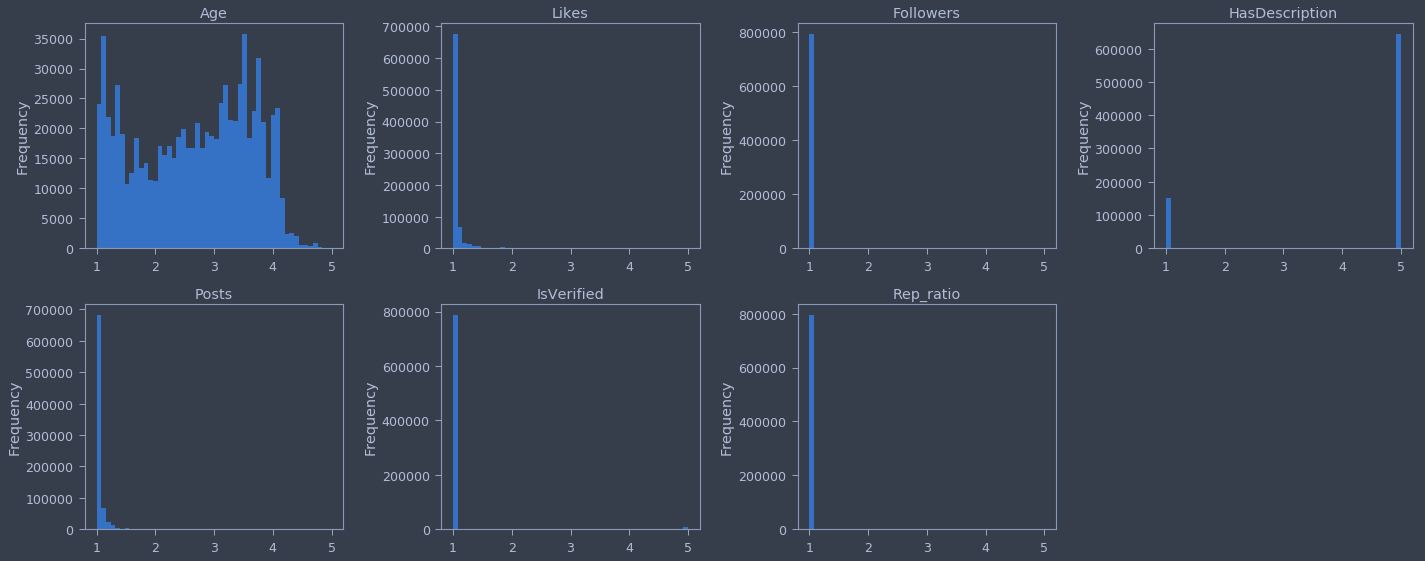

In [13]:
plt.figure(figsize=(20, 8))
for i, col in enumerate(df_norm):
    plt.subplot(2,4,i+1)
    df_norm[col].plot(kind="hist", bins=50)
    plt.title("%s"%col)
plt.tight_layout()

    → An extreme outliers (assumed to be celebrities' accounts) exists in data
    → Likes, Followers, Posts, Rep_ratio: Try Logarithm?

In [14]:
# for col in ["Likes", "Followers", "Posts"]:
#     df[col] = np.log(df[col]+3).values
# df["Rep_ratio"] = np.log(df[col]*100).values
# df_norm = pd.DataFrame(data = scale.fit_transform(df), columns=df.columns, index=df.index)

# plt.figure(figsize=(20, 8))
# for i, col in enumerate(df_norm):
#     plt.subplot(2,4,i+1)
#     df_norm[col].plot(kind="hist", bins=50)
#     plt.title("%s"%col)
# plt.tight_layout()

In [15]:
df_norm["IsVerified"].value_counts()

1.0    787514
5.0      8353
Name: IsVerified, dtype: int64

In [16]:
df_norm["HasDescription"].value_counts()

5.0    643850
1.0    152017
Name: HasDescription, dtype: int64

In [17]:
df_norm.head()

,Age,Likes,Followers,HasDescription,Posts,IsVerified,Rep_ratio
971292052045680640,1.022493,1.000605,1.000003,1.0,1.000194,1.0,1.000000
971292069305122816,2.861293,1.014032,1.000010,1.0,1.003035,1.0,1.000000
971292104981958658,1.022493,1.000609,1.000003,1.0,1.000196,1.0,1.000000
971292122035957760,1.865042,1.035824,1.000191,5.0,1.007278,1.0,1.000001
971292169154781184,1.716963,1.001805,1.000087,5.0,1.001043,1.0,1.000000


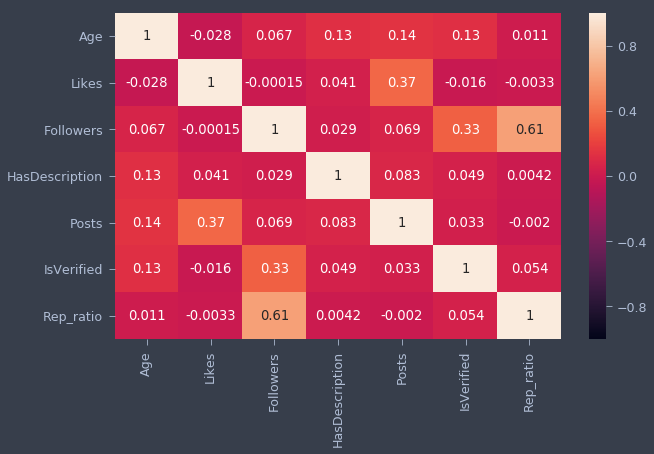

In [18]:
# reputation ratio and post have strong correlation
plt.figure(figsize=(10,6))
sns.heatmap(df_norm.corr(), vmin=-1, vmax=1, annot=True)

## 3.Score

### 1) Credibility
<code>IsVerified * Reputation Ratio * (Age + Followers + Posts + Likes + HasDescription)</code>

In [19]:
# Age
score_cred = df_norm["IsVerified"] * df_norm["Rep_ratio"] * (df_norm["Age"] + df_norm["Followers"] + df_norm["Posts"] + df_norm["Likes"] + df["HasDescription"])
score_cred.head()

971292052045680640    4.023297
971292069305122816    5.878373
971292104981958658    4.023303
971292122035957760    5.908339
971292169154781184    5.719900
dtype: float64

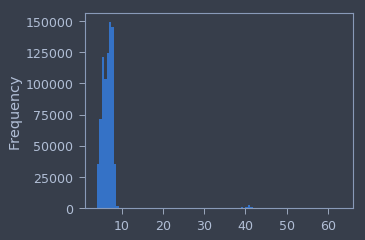

In [20]:
score_cred.plot("hist", bins=100)

In [21]:
# Another Approach: Sum up all factors
# score_cred = df_norm.sum(axis=1)
# score_cred.head()

In [22]:
# score_cred.plot("hist", bins=100)

In [23]:
df_norm.head()

,Age,Likes,Followers,HasDescription,Posts,IsVerified,Rep_ratio
971292052045680640,1.022493,1.000605,1.000003,1.0,1.000194,1.0,1.000000
971292069305122816,2.861293,1.014032,1.000010,1.0,1.003035,1.0,1.000000
971292104981958658,1.022493,1.000609,1.000003,1.0,1.000196,1.0,1.000000
971292122035957760,1.865042,1.035824,1.000191,5.0,1.007278,1.0,1.000001
971292169154781184,1.716963,1.001805,1.000087,5.0,1.001043,1.0,1.000000


### 2) Exposure

In [24]:
df["Followers"].value_counts().sort_index(ascending=False).head()

8041254    1
5135868    2
5135084    2
5133513    1
5119697    1
Name: Followers, dtype: int64

#### → Small number (1,2) of accounts which have huge (millions) followers

In [25]:
df["Followers"].value_counts().sort_index(ascending=False).tail()

4    2885
3    2692
2    2316
1    3129
0    3246
Name: Followers, dtype: int64

In [26]:
score_expo = df_norm["Followers"]
score_expo.head()

971292052045680640    1.000003
971292069305122816    1.000010
971292104981958658    1.000003
971292122035957760    1.000191
971292169154781184    1.000087
Name: Followers, dtype: float64

In [27]:
df_score = pd.concat([score_cred, score_expo], axis=1)
df_score.columns = ["credibility", "exposure"]
df_score.head()

,credibility,exposure
971292052045680640,4.023297,1.000003
971292069305122816,5.878373,1.000010
971292104981958658,4.023303,1.000003
971292122035957760,5.908339,1.000191
971292169154781184,5.719900,1.000087


In [28]:
df_score.max()

credibility    63.051219
exposure        5.000000
dtype: float64

#### PartiesMentioned

In [29]:
all_tweets = {}
for i in range(len(onlyfiles)):
    dict_path = archive_path"election_tweets%s.npy"%i
    tweets = np.load(dict_path).item()
    all_tweets.update(tweets)
len(all_tweets)

795867

In [30]:
partiesList  = ['pvda', 'vvd', 'pvv', 'denk', 'd66', 'fvd', 'cda',
                'groenlinks', 'christenunie', 'sgp', 'pvdd', 'sp', '50plus']

In [31]:
ref_d = dict(zip(partiesList, np.zeros(len(partiesList))))
l = []
tweets = list(all_tweets.values())[:]
for tweet in tweets:
    tweet = tweet.replace("@", "").replace("#", "").replace("/n", " ").lower().replace("groen links", "groenlinks")
    d = ref_d.copy()
    for party in partiesList:
        if party in tweet:
            d[party] += 1
    l.append(d)
df_partymentioned = pd.DataFrame(l)
df_partymentioned.index = df.index
partiesList  = ['pvda', 'vvd', 'pvv', 'denk', 'd66', 'fvd', 'cda',
                'groenlinks', 'christen', 'sgp', 'pvdd', 'sp', '50plus']
df_partymentioned.columns = partiesList
df_partymentioned.to_csv(archive_path+"df_partymentioned.csv")

In [32]:
df_partymentioned = pd.read_csv(archive_path+"df_partymentioned.csv", index_col=0)
df_partymentioned.head()

,pvda,vvd,pvv,denk,d66,fvd,cda,groenlinks,christen,sgp,pvdd,sp,50plus
971292052045680640,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971292069305122816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
971292104981958658,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971292122035957760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971292169154781184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def thresh(s):    
    low_thresh = np.percentile(s, 1/3*100)
    med_thresh = np.percentile(s, 2/3*100)
    return low_thresh, med_thresh

t1, t2 = thresh(df_score["exposure"])
df_score["level_expo"] = df_score["exposure"].apply(lambda x: "low" if x < t1 else "med" if x < t2 else "high").values
t1, t2 = thresh(df_score["credibility"])
df_score["level_cred"] = df_score["credibility"].apply(lambda x: "low" if x < t1 else "med" if x < t2 else "high").values

df_score.head()

,credibility,exposure,level_expo,level_cred
971292052045680640,4.023297,1.000003,low,low
971292069305122816,5.878373,1.000010,low,low
971292104981958658,4.023303,1.000003,low,low
971292122035957760,5.908339,1.000191,med,low
971292169154781184,5.719900,1.000087,low,low


In [34]:
df_final = df_partymentioned.join(df_score[["level_expo", "level_cred"]])
df_final.head()

,pvda,vvd,pvv,denk,d66,fvd,cda,groenlinks,christen,sgp,pvdd,sp,50plus,level_expo,level_cred
971292052045680640,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low,low
971292069305122816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,low,low
971292104981958658,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low,low
971292122035957760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,med,low
971292169154781184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low,low


## Plot

In [35]:
partiesList = df_partymentioned.columns

In [36]:
df_graph = pd.DataFrame(list(it.product(partiesList, ["low", "med", "high"])))

df_graph["level_expo"] = df_graph[1].apply(lambda x: x+"_expo")
all_data=[]
for party in partiesList:
    data = df_final[df_final[party] == 1.0]["level_expo"].value_counts().values.tolist()
    all_data += data
df_graph["count_expo"] = all_data

df_graph["level_cred"] = df_graph[1].apply(lambda x: x+"_cred")
all_data=[]
for party in partiesList:
    data = df_final[df_final[party] == 1.0]["level_cred"].value_counts().values.tolist()
    all_data += data
df_graph["count_cred"] = all_data

df_graph.columns="party", "level", "level_expo", "count_expo", "level_cred", "count_cred"
df_graph.head()

,party,level,level_expo,count_expo,level_cred,count_cred
0,pvda,low,low_expo,913,low_cred,981
1,pvda,med,med_expo,906,med_cred,832
2,pvda,high,high_expo,775,high_cred,781
3,vvd,low,low_expo,26669,low_cred,25728
4,vvd,med,med_expo,23881,med_cred,24850


### Barplot

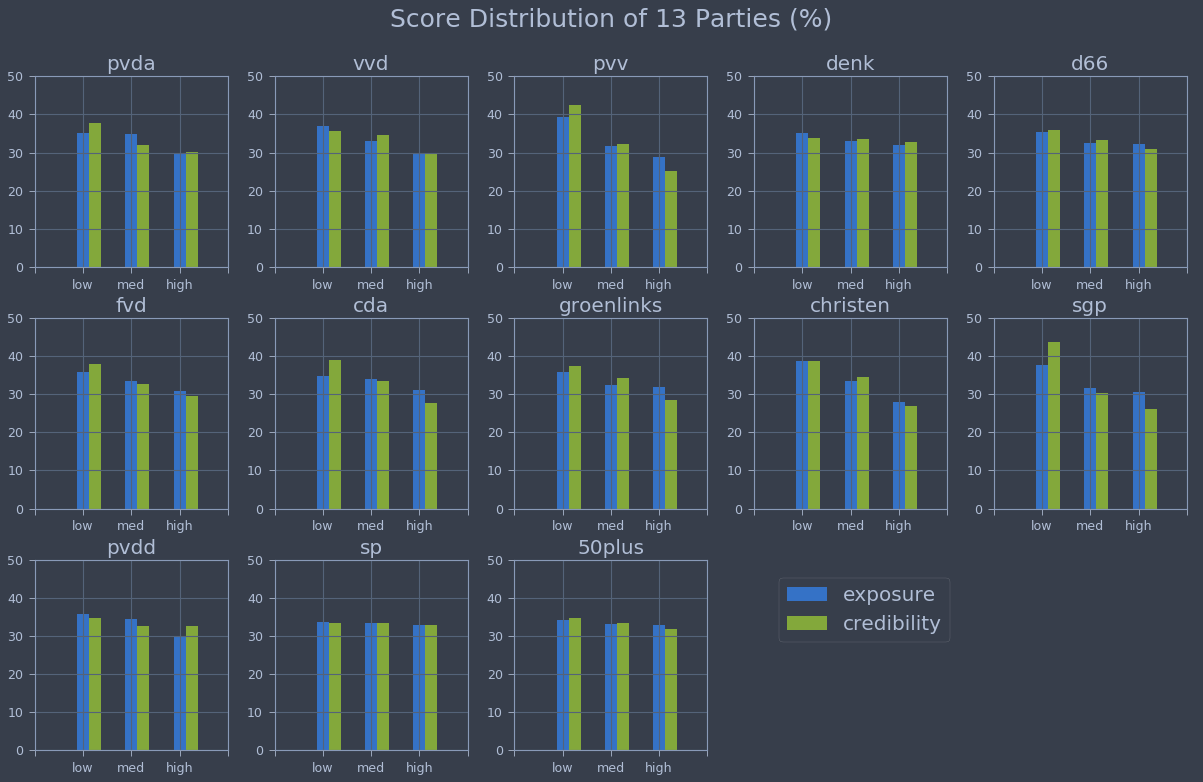

In [37]:
df_bar = df_graph.drop(["level_expo", "level_cred"], axis=1).set_index(["party", "level"])
df_bar.columns = ["exposure", "credibility"]
nrows = 3
ncols = 5
mul = 4
fig, axes = plt.subplots(figsize=(ncols*mul, nrows*mul),
                         nrows=nrows, ncols=ncols)
locs = list(it.product(range(nrows), range(ncols)))
for i in range(len(axes.flatten())):
    loc = locs[i]
    ax = axes[loc]
    if i < len(partiesList):
        party = partiesList[i]
        data = df_bar.loc[(party,slice(None))].copy()
        for j, col in enumerate(data):
            plot = data[col]
            plot = round((plot/plot.sum())*100, 1)
            ax.bar(np.arange(3)+j/4, height = plot.values, width=0.25, align="center", label=col)
        ax.set_title(party, size=20)
        ax.set_ylim(0,50)
        ax.set_xticks(range(-1,4))
        ax.set_xticklabels([""] + list(data.index))
        ax.grid()
        handles, labels = ax.get_legend_handles_labels()
    else:
        ax.axis("off")
fig.tight_layout()
fig.suptitle("Score Distribution of 13 Parties (%)", fontsize=25)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.6, 0.15), prop={'size': 20})
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)

In [38]:
pdf_pages.savefig(fig)

### NetworkX graph

In [39]:
def normalize(data):
    data = data / np.sum(data)
    return data

In [40]:
df_graph = pd.DataFrame(list(it.product(partiesList, ["low", "med", "high"])))

df_graph["level_expo"] = df_graph[1].apply(lambda x: x+"_expo")
all_data=[]
for party in partiesList:
    data = df_final[df_final[party] == 1.0]["level_expo"].value_counts().values.tolist()
    data = normalize(data).tolist()
    all_data += data
df_graph["count_expo"] = all_data

df_graph["level_cred"] = df_graph[1].apply(lambda x: x+"_cred")
all_data=[]
for party in partiesList:
    data = df_final[df_final[party] == 1.0]["level_cred"].value_counts().values.tolist()
    data = normalize(data).tolist()
    all_data += data
df_graph["count_cred"] = all_data

df_graph.columns="party", "level", "level_expo", "count_expo", "level_cred", "count_cred"
df_graph.head()

,party,level,level_expo,count_expo,level_cred,count_cred
0,pvda,low,low_expo,0.351966,low_cred,0.378180
1,pvda,med,med_expo,0.349268,med_cred,0.320740
2,pvda,high,high_expo,0.298766,high_cred,0.301079
3,vvd,low,low_expo,0.369869,low_cred,0.356818
4,vvd,med,med_expo,0.331202,med_cred,0.344641


In [41]:
# Create NX object
B = nx.Graph()
B.add_nodes_from(df_graph['party'], bipartite=0)
B.add_nodes_from(df_graph['level_expo'], bipartite=1)
B.add_nodes_from(df_graph['level_cred'], bipartite=2)

# Add edges
B.add_weighted_edges_from(
    [(row['party'], row['level_expo'], row["count_expo"]) for idx, row in df_graph.iterrows()], 
    weight='weight')

B.add_weighted_edges_from(
    [(row['party'], row['level_cred'], row["count_cred"]) for idx, row in df_graph.iterrows()], 
    weight='weight')

# Set Size of Nodes
s = df_graph.groupby(["level_expo", "level_cred"]).sum().reset_index()
s1 = s[["level_expo", "count_expo"]].set_index("level_expo")
s1 = s1/s1.sum()
s1 = s1/s1.max()
s1.index.name = None
s1.columns = ["values"]
s2 = s[["level_cred", "count_cred"]].set_index("level_cred")
s2 = s2/s2.sum()
s2 = s2/s2.max()
s2.index.name = None
s2.columns = ["values"]
lmhNodeSize = pd.concat([s1, s2]).reindex(list(B.nodes)[-6:])
lmhNodeSize = lmhNodeSize**5

nodeSize = df_partymentioned.sum().reindex(list(B.nodes))
nodeSize = df_partymentioned.sum().reindex(list(B.nodes)).fillna((lmhNodeSize*nodeSize.mean()).to_dict()["values"])
nodeSize = nodeSize/25

# Set edgeWidth
scale = MinMaxScaler(feature_range=(1,10))
edgesWeight=scale.fit_transform(np.array([u[2]["weight"] for u in B.edges.data()]).reshape(-1,1)).flatten()

# Set Position
pos = {node:[5*i, 0] for i,node in enumerate(df_graph["party"])}
xcoords = np.array([coord[0] for coord in pos.values()])
xcoords = [np.percentile(xcoords, perc) for perc in [15, 50, 85]]
xcoords = dict(zip(df_graph['level_expo'].unique(), xcoords))
xcoords = {node:[xcoord, 1.5] for node, xcoord in xcoords.items()}
pos.update(xcoords)

xcoords = np.array([coord[0] for coord in pos.values()])
xcoords = [np.percentile(xcoords, perc) for perc in [15, 50, 85]]
xcoords = dict(zip(df_graph['level_cred'].unique(), xcoords))
xcoords = {node:[xcoord, -1.5] for node, xcoord in xcoords.items()}
pos.update(xcoords)

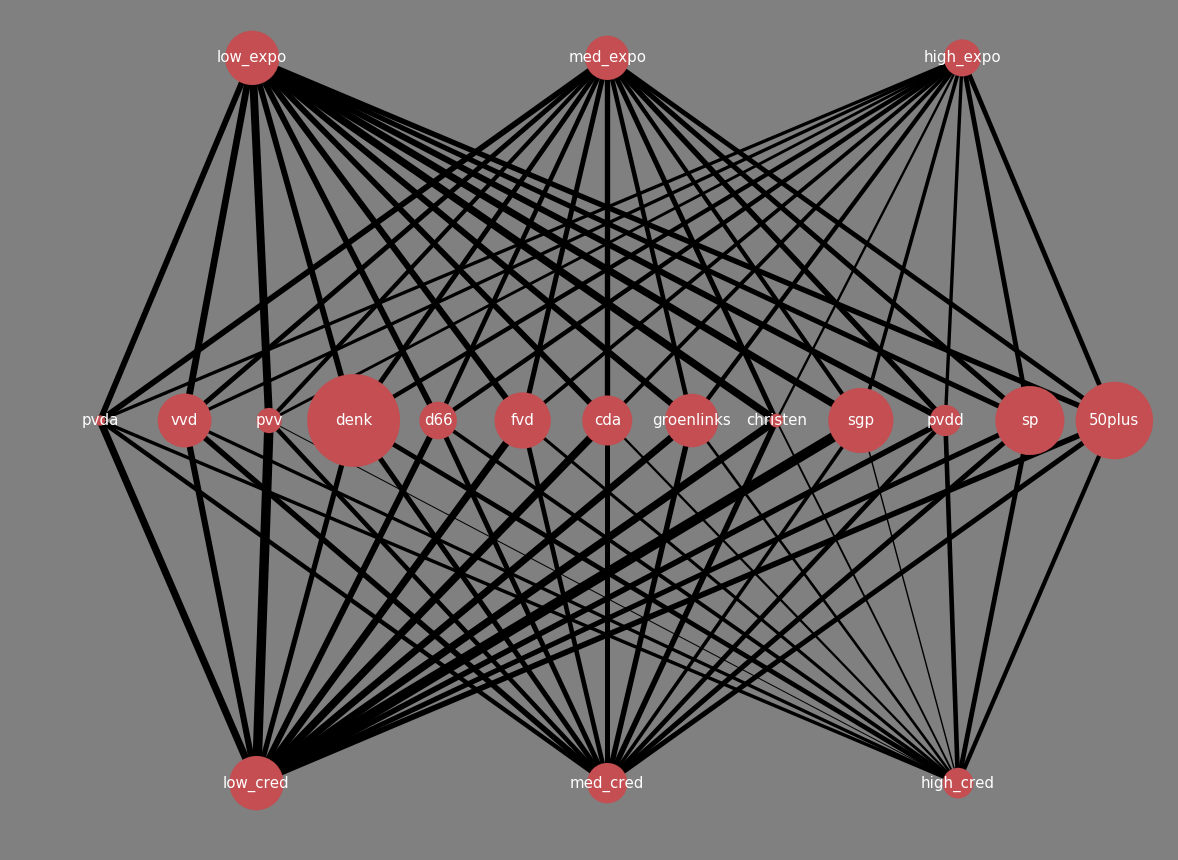

In [42]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))
nx.draw(B, pos, node_size=nodeSize,with_labels=False, 
        edge_color="black", width=edgesWeight,
        ax=ax)
nx.draw_networkx_labels(B, pos, font_color="white", font_size=15)
fig.set_facecolor("gray")

In [43]:
pdf_pages.savefig(fig)

### 2D Plot

In [44]:
df_2dplot = df_graph.sort_values("level").set_index(["level", "party"]).drop(["level_expo", "level_cred"], axis=1).T
df_2dplot

level           high                                                     \
party         50plus groenlinks       d66  christen      denk       fvd   
count_expo  0.328251   0.319196  0.321967  0.279060  0.318942  0.308714   
count_cred  0.318588   0.284672  0.309072  0.268924  0.327377  0.294627   

level                                                 ...          med  \
party            pvv       sgp      pvdd       vvd    ...       50plus   
count_expo  0.289350  0.306876  0.300050  0.298929    ...     0.329992   
count_cred  0.251559  0.259765  0.325572  0.298541    ...     0.333983   

level                                                                    \
party            pvv      pvdd groenlinks       vvd        sp       fvd   
count_expo  0.316580  0.343346   0.323627  0.331202  0.335191  0.333914   
count_cred  0.323196  0.326856   0.341855  0.344641  0.335140  0.326158   

level                                     
party           pvda       d66       cda  
count_expo  0.349268  0.324546  0.340671  
count_cred  0.320740  0.332913  0.333548  

[2 rows x 39 columns]

In [45]:
scale = MinMaxScaler(feature_range=(-1,1))
df_2dplot = (df_2dplot.loc[:,"high"] - df_2dplot.loc[:,"low"]).T
df_2dplot = pd.DataFrame(scale.fit_transform(df_2dplot), index=df_2dplot.index, columns=df_2dplot.columns)

Text(0.5,0.98,'Credibility and Exposure Score of 13 Parties')

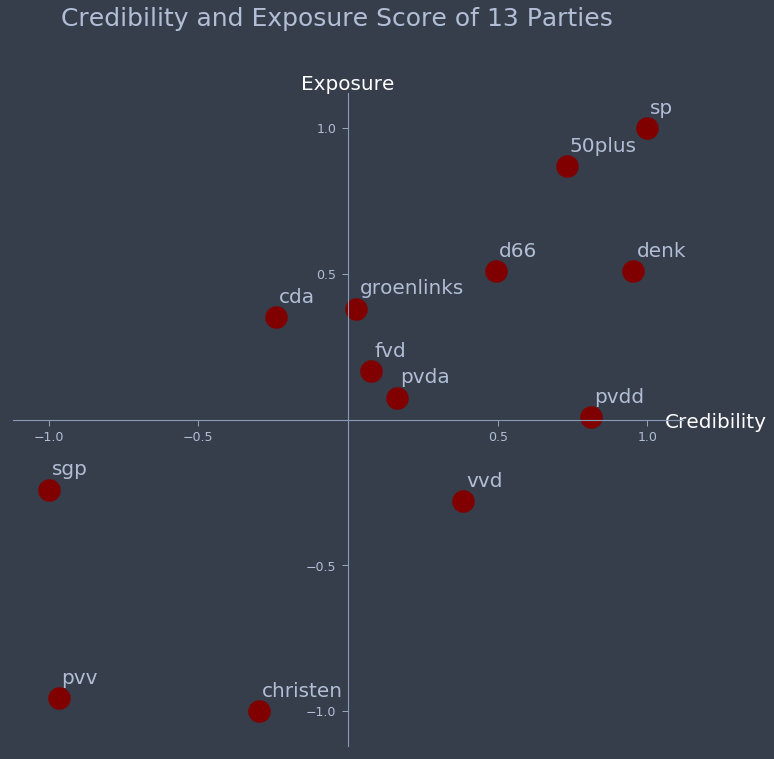

In [46]:
fig,ax=plt.subplots(figsize=(12,12))
x = df_2dplot["count_cred"]
y = df_2dplot["count_expo"]
ax.scatter(x,y,s=500,color="maroon")
for i, txt in enumerate(df_2dplot.index):
    ax.annotate(txt, (x[i]+0.01, y[i]+0.05), size=20)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xticks([-1,-0.5,0.5,1])
ax.set_yticks([-1,-0.5,0.5,1])
ax.set_xlabel("Credibility", size=20, color="white")
ax.xaxis.set_label_coords(1.05, 0.51)
ax.set_ylabel("Credibility", size=20, color="white", rotation=0)
ax.yaxis.set_label_coords(0.5, 1)
ax.set_ylabel("Exposure")
fig.suptitle("Credibility and Exposure Score of 13 Parties", size=25)

In [47]:
pdf_pages.savefig(fig)
pdf_pages.close()